In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from PIL import Image

from sklearn import metrics

import cv2
import numpy as np
import os

from glob import glob

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')


In [6]:
# Extracting the compressed dataset.
from zipfile import ZipFile
data_path = 'fer2013.zip'

with ZipFile(data_path,'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')


The data set has been extracted.


In [7]:
path = 'train'
classes = os.listdir(path)
classes


['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

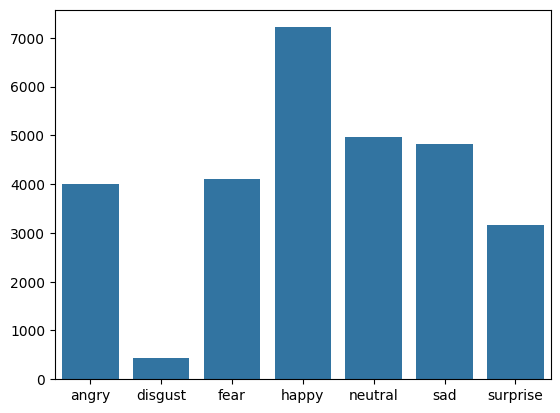

In [9]:
count = []
for cat in classes:
	count.append(len(os.listdir(f'{path}/{cat}')))
sb.barplot(x=classes,y=count)
plt.show()


In [10]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
		'train',
		target_size=(48,48),
		batch_size=64,
		color_mode="grayscale",
		class_mode='categorical')

val_gen = val_datagen.flow_from_directory(
		'test',
		target_size=(48,48),
		batch_size=64,
		color_mode="grayscale",
		class_mode='categorical')


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [11]:
emotions = list(train_gen.class_indices.keys())


In [12]:
model = keras.models.Sequential([
									layers.Conv2D(32,(3,3),activation='relu',input_shape=(48, 48, 1)),
									layers.Conv2D(64,(3,3),activation='relu'),
									layers.MaxPooling2D(2,2),


									layers.Flatten(),
									layers.Dense(64,activation='relu'),
									layers.BatchNormalization(),
									layers.Dense(32,activation='relu'),
									layers.Dropout(0.3),
									layers.BatchNormalization(),
									layers.Dense(7, activation='softmax')
])


In [13]:
model.compile(
	optimizer = 'adam',
	loss = 'categorical_crossentropy',
	metrics=['accuracy']
)


In [14]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
	  if logs.get('val_accuracy') > 0.90:
	    print('\n Validation accuracy has reached upto 90% so, stopping further training.')
	    self.model.stop_training = True

es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(monitor = 'val_loss', patience = 2, factor=0.5, verbose=1)


In [29]:
history = model.fit(train_gen, 
                    validation_data = val_gen, 
                    epochs = 5, 
                    verbose = 1, 
                    callbacks = [es, lr, myCallback()])

# Save the trained model to a file
model.save('emotion_model.h5')  # Provide the desired file path for saving the model
print('Model has been saved.')


Epoch 1/5
449/449 [==============================] - 116s 259ms/step - loss: 1.2642 - accuracy: 0.5169 - val_loss: 1.8137 - val_accuracy: 0.4186 - lr: 0.0010
Epoch 2/5
449/449 [==============================] - 112s 250ms/step - loss: 1.1584 - accuracy: 0.5625 - val_loss: 1.4789 - val_accuracy: 0.4310 - lr: 0.0010
Epoch 3/5
449/449 [==============================] - 113s 252ms/step - loss: 1.0462 - accuracy: 0.6056 - val_loss: 1.5033 - val_accuracy: 0.4635 - lr: 0.0010
Epoch 4/5
449/449 [==============================] - ETA: 0s - loss: 0.9322 - accuracy: 0.6537
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
449/449 [==============================] - 114s 253ms/step - loss: 0.9322 - accuracy: 0.6537 - val_loss: 1.4997 - val_accuracy: 0.5003 - lr: 0.0010
Epoch 5/5
449/449 [==============================] - 113s 253ms/step - loss: 0.7251 - accuracy: 0.7385 - val_loss: 1.4792 - val_accuracy: 0.5153 - lr: 5.0000e-04
Model has been saved.


In [16]:
def plot_image(img, emoj):
	wmin = 256
	hmin = 256

	emoj = cv2.resize(emoj, (wmin, hmin))
	img = cv2.resize(img, (wmin, hmin))
	cv2.imshow('Images', cv2.hconcat([img, emoj]))


In [36]:
import cv2
import numpy as np

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Load the pre-trained model and classes
model = keras.models.load_model('emotion_model.h5')  # Provide the path to your pre-trained model file
classes = emotions  # Assuming 'emotions' variable contains the list of emotion classes

# Assuming 'plot_image' function is already defined
def plot_image(img, emoj):
    wmin = 256
    hmin = 256
    emoj = cv2.resize(emoj, (wmin, hmin))
    img = cv2.resize(img, (wmin, hmin))
    cv2.imshow('Images', cv2.hconcat([img, emoj]))

# Assuming 'train_gen' is your training data generator
for img_path in glob('path_to_your_images_directory/*.jpg'):  # Provide the path to the directory containing your images
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    
    for (x, y, w, h) in faces:
        gray_face = gray[y:y + h, x:x + w]
        gray_face = cv2.resize(gray_face, (48, 48))
        gray_face = np.expand_dims(gray_face, axis=-1)
        gray_face = np.expand_dims(gray_face, axis=0)

        pred = model.predict(gray_face)
        idx = pred.argmax(axis=-1)[0]

        emoj = cv2.imread(f'emojis/{classes[idx]}.jpg')  # Assuming emoji images are stored in the 'emojis' directory

        plot_image(img, emoj)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cv2.destroyAllWindows()
